[N-rozměrná koule](https://en.wikipedia.org/wiki/Volume_of_an_n-ball)

## Určení obsahu jednotkového kruhu pomocí metody Monte Carlo.

Označme $S$ jednotkový kruh a $C$ jemu opsaný čtverec $[-1, 1]\times[-1, 1]$. 
Pokud vezmeme náhodný bod uvnitř $C$ (o obsahu $4$), je pravděpodobnost $p$, že bod bude uvnitř kruhu rovna
$$ p = \frac{|S|}{|C|} = \frac{|S|}{4} $$
Metoda Monte Carlo spočívá ve vygenerování velkého množství náhodných bodů a určení podílu těch, padly dovnitř kruhu. V tomto jednoduchém případě víme, že přesná hodnota je $$ p = \frac{\pi}{4} $$. 

In [1]:
import random
import numpy as np


def get_point():
    return [random.uniform(-1,1), random.uniform(-1,1)]


def is_in_disk(x, y):
    return x*x+y*y < 1


    

In [2]:
import matplotlib.pyplot as plt
class McSamples:
    """
    Class to collect MC samples for different sample sizes.
    """
    def __init__(self):
        # Number of generated samples in individual groups.        
        self.n_samples = [0]
        # Number of samples in the disk.
        self.n_in_disk = [0]
        
        
    def add_samples(self, n_total_samples):
        """
        Generate more samples to have 'n_total_samples' in total.
        """
        n = self.n_samples[-1]
        n_in = self.n_in_disk[-1]
        while n < n_total_samples:
            x, y = get_point()
            n+=1        
            n_in += is_in_disk(x, y)            
        self.n_samples.append(n)
        self.n_in_disk.append(n_in)
    
    def all_samples(self, sizes):
        """
        Generate samples for given array of increasind sample sizes.
        """
        for size in sample_sizes:
            self.add_samples(size)
        self.process()    
            
    def process(self):
        n = self.n_samples = np.array(self.n_samples[1:], dtype=float)
        self.n_in_disk = np.array(self.n_in_disk[1:], dtype=float)
        self.approx_pst = self.n_in_disk/n
        self.exact_pst = np.pi / 4    
        self.exact_sigma = (1 - self.exact_pst)*self.exact_pst
        self.error = np.abs(self.approx_pst - self.exact_pst)
        self.estim_error = self.exact_sigma / np.sqrt(n)
        
    def error_table(self):       
        print("{:10} {:10} {:10} {:10}".format("pow", "approx", "error", "err/err_est")) 
        for i in range(len(self.n_samples)):
            print("{:<10.1f} {:<10.6f} {:<10.2e} {:<10.1f}".format(
                np.log10(self.n_samples[i]), 4*self.approx_pst[i], 
                self.error[i], self.error[i] / self.estim_error[i]))

      
    def error_plot(self):
        X = self.n_samples
        fig = plt.figure(figsize=(10,5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        ax1.set_xscale("log")
        #ax1.set_yscale("log", nonposy='clip')
        ax1.plot(X, self.approx_pst)
        ax1.plot([X[0],X[-1]], 2*[self.exact_pst])
                
        ax2.set_xscale("log")
        ax2.set_yscale("log")
        ax2.set_ylabel("error")
        ax2.plot(X, self.error)    
        ax2.plot(X, self.estim_error)   
        plt.show()
    


In [3]:
from timeit import default_timer as timer

powers = [1, 2, 3, 4, 5, 6, 7]
sample_sizes = [10**i for i in powers]

mc = McSamples()
begin = timer()
mc.all_samples(sample_sizes)
end = timer()
print("Sampling time: ", end - begin)



Sampling time:  9.48889644800147


Zde je vidět poněkud slabý výpočetní výkon Pythonu, na jeden vzorek (sample) potřebujeme řádově 1000 taktů procesoru.


pow        approx     error      err/err_est
1.0        3.200000   1.46e-02   0.3       
2.0        3.200000   1.46e-02   0.9       
3.0        3.068000   1.84e-02   3.5       
4.0        3.122800   4.70e-03   2.8       
5.0        3.134640   1.74e-03   3.3       
6.0        3.142412   2.05e-04   1.2       
7.0        3.141571   5.46e-06   0.1       


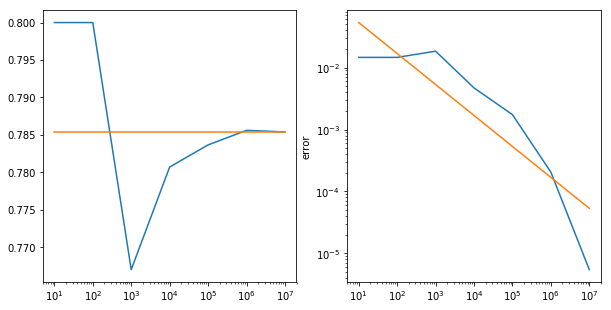

In [4]:
# Print sequence of MC approximations
mc.error_table()
mc.error_plot()


S rostoucím počtem vzorků nám klesá chyba, ale velmi pomalu s odmocninou z počtu vzorků, t.j. poslední sloupec je přibližně 1.

Sampling time:  0.30823138399864547
pow        approx     error      err/err_est
1.0        3.200000   1.46e-02   0.3       
2.0        3.040000   2.54e-02   1.5       
3.0        3.112000   7.40e-03   1.4       
4.0        3.148000   1.60e-03   1.0       
5.0        3.153600   3.00e-03   5.6       
6.0        3.141940   8.68e-05   0.5       
7.0        3.141648   1.39e-05   0.3       


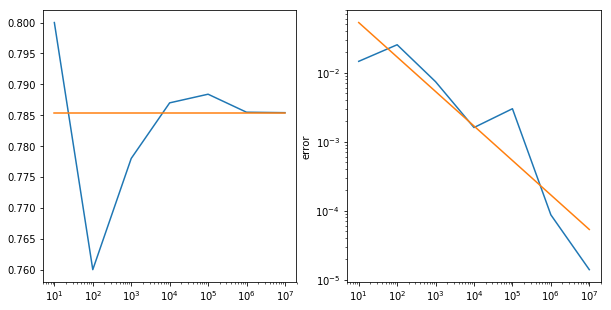

In [15]:
block_size = 4*1024

class McSamplesNP(McSamples):
    
    def samples_block(self, n):
        XY = np.random.rand(n, 2)
        return np.sum( np.sum(XY**2, axis = -1) < 1.0 )
    
    def add_samples(self, n_total_samples):
        """
        Generate more samples to have 'n_total_samples' in total.
        """
        
        n = self.n_samples[-1]
        n_in = self.n_in_disk[-1]
        
        while n < n_total_samples: 
            n_to_add = min(block_size, n_total_samples - n)            
            n_in  += self.samples_block(n_to_add)
            n += n_to_add
        
        self.n_samples.append(n_total_samples)
        self.n_in_disk.append(n_in)
        
powers = [1, 2, 3, 4, 5, 6, 7]
sample_sizes = [10**i for i in powers]        
        
mc = McSamplesNP()        
begin = timer()
mc.all_samples(sample_sizes)
end = timer()
print("Sampling time: ", end - begin)

mc.error_table()
mc.error_plot()


Pomocí použití Numpy sice převedeme většinu výpočtu do kompilované knihovny a dosáhneme asi 30x urychlení, 
ale zase je tento přístup zbytečně náročný na paměť a vyžeduje opakovaný přístup do paměti.
To nyní pomineme a pokusíme se o urychlení pomocí paralelního zpracování.

Existují dva koncepty:

    1. Spuštění více procesů -- instancí stejného programu. Výhodou je úplné oddělení procesů, 
    nevýhodou N kopií programu v paměti a složitější komunikace mezi procesy.
    
    2. Spuštění více vláken (thread) v rámci jednoho programu. Výhodou je rychlejší spouštění vláken, 
    menší nároky na paměť a snadnější komunikace vláken, nevýhodou je složitější ladění a problémy s 
    globálními proměnnými. 
    
Efektivní využití dnešního HW vyžaduje použití obou přístupů:
    1. Výpočetní cluster je sestaven ze samostatných počítačů, tzv. uzlů. Na každém uzlu běží samostatný proces, 
    který komunikuje s procesy na jiných uzlech pomocí posílání zpráv (MPI viz. dále).
    
    2. V rámci jednoho uzlu si proces vytvoří více výpočetních vláken, aby využil všechna jádra uzlu.
    
    3. Optimalizace. Pro maximální využití výpočetních prostředků se provádějí optimalizace na správné využití cache a 
    vektorových výpočetních operací.

## Global Interpreter Lock (GIL)

Python umí používat vlákna, ale zároveň používá globální zámek, který praktický zajistí, že v každý okamžik aktuálně běží pouze jedno z existujících vláken. Zde se ukazuje, že Python (podobně jako mnoho dalšího SW) nebyl na vícevláknový běh navržen a pro zaručení konzistentního stavu všech interních operací to bylo vyřešeno globálním zámkem. Využití vláken v Pythonu tedy je vhodné pro:
- obsluhu asynchonních událostí (komunikace po síti, přerušení)
- zefektivnění operací (síť, disk) které neváznou na procesoru

Tento koncept se nazývá "concurency programming" narozdíl od "parallel programming", kde chceme aby více vláken nebo procesů běželo současně. Standardní knihovna pythonu poskytuje dva moduly s podobným rozhraním: modul `threading` pro 
práci s vlákny synchronyzovanými pomocí GIL a modul `multiprocessing` pro koordinaci více samostatných procesů. Je třeba upozornit, že GIL nevyužívají všechny implementace Pythonu.
- CPython - GIL, referenční implementace
- PyPy - GIL, just-in-time compiler (cca 5x zrychlení), mírná omezení oproti Pythonu
- Jython - no GIL, kompilace do JAVA byte kódu
- IronPython - no GIL, založeno na Microsoft .NET platformě

Tj. s použitím Jthonu nebo IronPythonu běží vlákna skutečně paralelně.

modul multiprocessing

Výpočet vzroků v metodě MC rozdělíme na více procesů, při vytvoření procesu mu předáme funkci kterou má spustit spolu s
jejími parametry. Parametry zahrnují i frontu `counts` pro uložení výsledků.


svmem(total=8014913536, available=550391808, percent=93.1, used=7040077824, free=611377152, active=5528580096, inactive=1281142784, buffers=4747264, cached=358711296, shared=200945664)
svmem(total=8014913536, available=451665920, percent=94.4, used=7138746368, free=512610304, active=5617811456, inactive=1281155072, buffers=4763648, cached=358793216, shared=200962048)
[0, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
[0, 5, 73, 780, 7896, 78651, 785919, 7852920, 78540457]
Sampling time:  0.8601053380007215
pow        approx     error      err/err_est
1.0        2.000000   2.85e-01   5.4       
2.0        2.920000   5.54e-02   3.3       
3.0        3.120000   5.40e-03   1.0       
4.0        3.158400   4.20e-03   2.5       
5.0        3.146040   1.11e-03   2.1       
6.0        3.143676   5.21e-04   3.1       
7.0        3.141168   1.06e-04   2.0       
8.0        3.141618   6.41e-06   0.4       


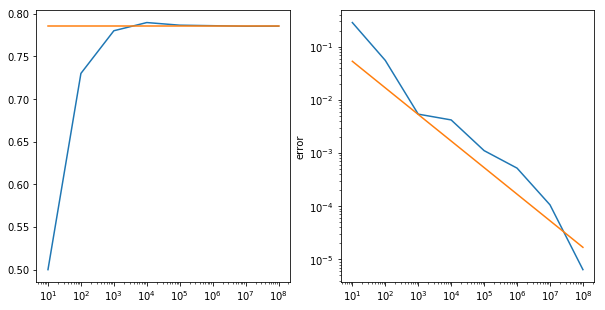

In [33]:
import multiprocessing
import psutil

block_size = 8 * 1024
class PoolMC(McSamplesNP):

    def __init__(self):
        super().__init__()

    def work_block(self, args):
        ii, n, seed = args
        np.random.seed(seed)
        n_in = self.samples_block(n)
        return (ii, n_in)
        
    def make_blocks(self, ii, n_total_samples):
        """
        Generate more samples to have 'n_total_samples' in total.
        """
        n = self.n_samples[-1]
        self.n_samples.append(n_total_samples)
        self.n_in_disk.append(0)

        blocks = []    
        while n < n_total_samples: 
            n_to_add = min(block_size, n_total_samples - n)                        
            n += n_to_add
            #print(ii, n_to_add)
            blocks.append( (ii+1, n_to_add, np.random.randint(10000)) )
            #blocks.append( (ii+1, n_to_add, 1) )
        return blocks
    
    def process(self, block_results):
        """
        Wait for subprocesses and connect results. Then call original processing.
        """
        for ii, n_in in block_results:
            self.n_in_disk[ii] += n_in
        n_in_total=0
        for i, n_in in enumerate(self.n_in_disk):
            self.n_in_disk[i] +=n_in_total
            n_in_total += n_in
        print(self.n_samples)
        print(self.n_in_disk)
        super().process()
        
    def all_samples(self, sizes):
        """
        Generate samples for given array of increasind sample sizes.
        """
        print(psutil.virtual_memory())
        blocks = []
        for i, size in enumerate(sample_sizes):
            blocks.extend(self.make_blocks(i, size))
        pool = multiprocessing.Pool(8)
        block_res = pool.map(self.work_block, blocks)
        print(psutil.virtual_memory())
        self.process(block_res)        

powers = [1, 2, 3, 4, 5, 6, 7, 8]
sample_sizes = [10**i for i in powers]

mc = PoolMC()        
begin = timer()
mc.all_samples(sample_sizes)
end = timer()
print("Sampling time: ", end - begin)

mc.error_table()
mc.error_plot()

Slabé místo tohoto řešení: 
- nesmyslně velké množství procesů spuštěných najednou, smysluplné max. 6-8 procesů
- různě náročné bloky = procesy

Vhodné je vytvořit pevnou množinu procesů a v ní spoutět  dálčí úlohy.
Jelikož vytváření procesů je drahé, používá se tzv. Pool. Tedy pevná množina procesů, které se vytvoří jen jednou a pak se jim přiřazuje práce, kterou mají vykonat.

In [11]:
    def process(self):
        """
        Wait for subprocesses and connect results. Then call original processing.
        """
        n_alive_jobs = 1
        while (n_alive_jobs > 0):
            while not self.block_queue.empty():
                ii, n_in = self.block_queue.get()
                self.n_in_disk[ii] += n_in
            jobs.is_alive()    
            n_alive_jobs = sum([job.is_alive() for job in self.jobs])
        for job in self.jobs:
            job.join()

        super().process()


Jelikož vytváření procesů je drahé, používá se tzv. Pool. Tedy pevná množina procesů, které se vytvoří jen jednou a pak se jim přiřazuje práce, kterou mají vykonat.